## Statistical Thinking in Python 2

* [Hypothesis Testing](#hypothesis)
* [Hypothesis Test Examples](#examples)

**Pipeline for Hypothesis Testing**
- clearly state the null hypothesis
- define your test statistic
- generate many sets of simulated data assuming the null hypothesis is true
- compute the test statistic for each simulated dataset
- p-value is the fraction of your simulated datasets for which the test statistic is at least as extreme as for the real data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [20]:
# create a function to return CDF axis
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y


def vis_ecdf(data1, data2, label1, label2):
    x1, y1 = ecdf(data1)
    x2, y2 = ecdf(data2)
    
    plt.plot(x1, y1, marker='.', linestyle='none', label=label1)
    plt.plot(x2, y2, marker='.', linestyle='none', label=label2)
    plt.legend(loc=4)

    
def permutation_sample(data1, data2):
    both = np.concatenate((data1, data2))
    perm = np.random.permutation(both)
    return perm[:len(data1)], perm[len(data1):]
    
    
def draw_perm_reps(data1, data2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data1, data2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates


def diff_of_means(data1, data2):
    return np.mean(data1) - np.mean(data2)

In [14]:
# read all the data necessary
speed_of_light = pd.read_csv('datasets/speed_of_light.csv', index_col=0)
no_hitters = pd.read_csv('datasets/major_league_baseball_no_hitters.csv')
swing_states = pd.read_csv('datasets/swing_states.csv')
female_literacy = pd.read_csv('datasets/female_literacy.csv')
bees = pd.read_csv('datasets/bee_sperm.csv')
frogs = pd.read_csv('datasets/frog_tongue.csv')

In [6]:
swing_states.head(2)

,state,county,total_votes,dem_votes,rep_votes,dem_share
0,PA,Erie County,127691,75775,50351,60.08
1,PA,Bradford County,25787,10306,15057,40.64


### Hypothesis Testing

We will look at an example where we hypothesize that PA and OH have identical county-level voting. Using **hypothesis testing** we will assess how reasonable the observed data are assuming the hypothesis is true. The hypothesis we're testing is **null hypothesis**. We will start by plotting the two ECDFs of country-level votes. Then, we will simulate the data while ignoring what state they belong to. Then, we randomly scramble the ordering of the counties. Next, we will split the data and look at the difference. 

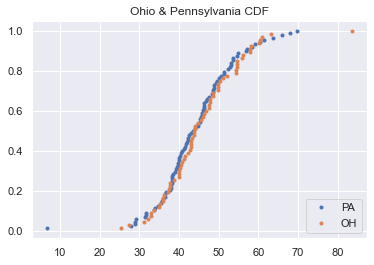

In [7]:
oh_dem_share = swing_states[swing_states['state'] == 'OH']['dem_share']
pa_dem_share = swing_states[swing_states['state'] == 'PA']['dem_share']

# show cdfs
plt.title('Ohio & Pennsylvania CDF')
vis_ecdf(oh_dem_share, pa_dem_share, 'PA', 'OH')
plt.show()

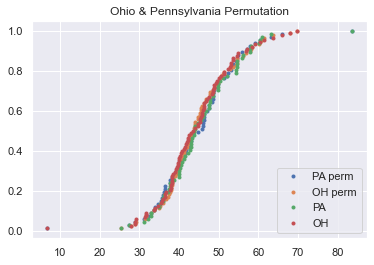

In [10]:
# generate permutations
perm_sample_pa, perm_sample_oh = permutation_sample(pa_dem_share, oh_dem_share)

# show cdfs
plt.title('Ohio & Pennsylvania Permutation')
vis_ecdf(perm_sample_pa, perm_sample_oh, 'PA perm', 'OH perm')
vis_ecdf(pa_dem_share, oh_dem_share, 'PA', 'OH')
plt.show()

In [12]:
print('Permutation difference:', np.mean(perm_sample_pa) - np.mean(perm_sample_oh))
print('Actual difference:', np.mean(pa_dem_share) - np.mean(oh_dem_share))

Permutation difference: 0.07171132971506466
Actual difference: 1.1582360922659447


**Example: Frog tongue length** will consist of the EDA step, followed by hypothesis testing. 

Kleinteich and Gorb (Sci. Rep., 4, 5225, 2014) performed an interesting experiment with South American horned frogs. They held a plate connected to a force transducer, along with a bait fly, in front of them. They then measured the impact force and adhesive force of the frog's tongue when it struck the target.

Frog A is an adult and Frog B is a juvenile. The researchers measured the impact force of 20 strikes for each frog. In the next exercise, we will test the hypothesis that the two frogs have the same distribution of impact forces. But, remember, it is important to do EDA first!

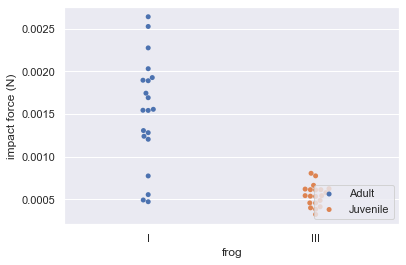

In [18]:
frogs_adults_juvenile = frogs[(frogs['ID'] == 'I') | (frogs['ID'] == 'III')][['ID', 'impact force (mN)']]
frogs_adults_juvenile['impact force (N)'] = frogs_adults_juvenile['impact force (mN)'] / 1000000 
sns.swarmplot(data=frogs_adults_juvenile, x='ID', y='impact force (N)')
plt.xlabel('frog')
plt.ylabel('impact force (N)')
plt.legend(['Adult', 'Juvenile'], loc=4)
plt.show()

In [23]:
force_adults = np.array([1.612, 0.605, 0.327, 0.946, 0.541, 1.539, 0.529, 0.628, 1.453,
                         0.297, 0.703, 0.269, 0.751, 0.245, 1.182, 0.515, 0.435, 0.383,
                         0.457, 0.73 ])
force_juvenile = np.array([0.172, 0.142, 0.037, 0.453, 0.355, 0.022, 0.502, 0.273, 0.72 ,
                           0.582, 0.198, 0.198, 0.597, 0.516, 0.815, 0.402, 0.605, 0.711,
                           0.614, 0.468])

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_adults, force_juvenile)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_adults, force_juvenile, diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0043


The p-value tells you that there is about a 0.4% chance that you would get the difference of means observed in the experiment if frogs were exactly the same. A p-value below 0.01 is typically said to be "statistically significant," but: warning! warning! warning! You have computed a p-value; it is a number. I encourage you not to distill it to a yes-or-no phrase. p = 0.004 and p = 0.000000004 are both said to be "statistically significant," but they are definitely not the same!